# データ生成

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (d.reshape(num, w * h), Y)

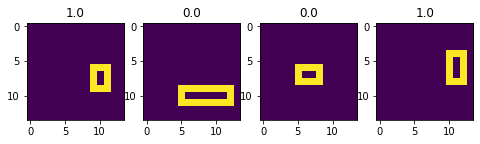

In [2]:
X, Y = data = make_rectangles_dataset(100, 14, 14)
Xt, Yt = test_data = make_rectangles_dataset(100, 14, 14)

plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(14,14))
    plt.title(Y[i, 0])

# RBFカーネルのGP

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class GP:
  def __init__(self, dim, device="cuda" ):
    self.beta = 10.0
    self.dim = dim
    self.device = device

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt).reshape(-1,self.dim)
    self.yt = torch.tensor(yt)
    N = len(xt)

    # to gpu
    self.xt = self.xt.to(self.device)
    self.yt = self.yt.to(self.device)

    # カーネル行列を定義
    self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N, device=self.device)/self.beta
    self.K_inv = torch.inverse( self.K )
  
  def predict( self, x ):
    x = torch.tensor(x, device=self.device).reshape(-1,self.dim)

    kx = self.cov( x, self.xt )
    k = self.cov( x, x) + 1.0/self.beta

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()

In [5]:
gp = GP(196, "cpu")
gp.learn( X.reshape((-1,196)), Y )


mu, sig = gp.predict(X)
acc = np.sum((mu>0.5)==Y.flatten())/Y.shape[0]
print("train acc", acc)

mu, sig = gp.predict(Xt)
acc = np.sum((mu>0.5)==Yt.flatten())/Yt.shape[0]
print("test acc", acc)


train acc 1.0
test acc 0.48


# 畳み込みGP

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class ConvGP:
  def __init__(self, h, w, patch_size,  device="cuda" ):
    self.beta = 10.0
    self.device = device
    self.patch_size = patch_size
    n_channels = 1
    self.num_patches = (h - self.patch_size + 1) * (w - self.patch_size + 1) * n_channels

  def k(self, xi, xj, axis=2):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), axis)) 

  def get_patches(self, x):
    H = x.shape[2] 
    W = x.shape[3]
    n_channels = x.shape[1] 

    patches = x.unfold(2, self.patch_size, 1).unfold(3, self.patch_size, 1)
    patches = patches.reshape( (x.shape[0],n_channels*self.num_patches, self.patch_size*self.patch_size) )
    return patches

  def cov(self, x1, x2):
    xp1 = self.get_patches(x1)
    xp2 = self.get_patches(x2)


    # 一気に計算するとメモリが足りなくなる・・・
    """
    # 一次元増やしてパッチをコピー
    xp1 = xp1.view(xp1.shape[0], xp1.shape[1], 1, xp1.shape[2] )  #.repeat(1, 1, self.num_patches, 1)
    print(xp1.shape)

    # 一次元増やしてデータをコピー
    xp1 = xp1.view(xp1.shape[0], 1, xp1.shape[1], xp1.shape[2], xp1.shape[3]  ) #.repeat(1, len(xp2), 1, 1, 1)

    # 一次元増やしてパッチをコピー
    xp2 = xp2.view(xp2.shape[0], 1, xp2.shape[1], xp2.shape[2] ) #.repeat(1, self.num_patches, 1, 1 )

    # 一次元増やしてデータをコピー
    xp2 = xp2.view(1, xp2.shape[0], xp2.shape[1], xp2.shape[2], xp2.shape[3]  ) #.repeat(len(xp1), 1, 1, 1, 1)

    K = self.k( xp1, xp2, 4 ) 

    return torch.sum(K, [2,3])
    """

    N1 = xp1.shape[0]
    N2 = xp2.shape[0]
    K = torch.zeros(N1, N2, device=self.device)

    for n1 in range(N1):
      for n2 in range(N2):
        xpn1 = xp1[n1]
        xpn2 = xp2[n2]
        xpn1 = xpn1.view(xpn1.shape[0], 1, xpn1.shape[1] )
        xpn2 = xpn2.view(1, xpn2.shape[0], xpn2.shape[1] )
        K[n1, n2] = torch.sum(self.k( xpn1, xpn2 ))

    return K


  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt, dtype=torch.float32, device=self.device)
    self.yt = torch.tensor(yt, dtype=torch.float32, device=self.device)
    N = len(xt)

    # カーネル行列を定義
    self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N, device=self.device)/self.beta
    self.K_inv = torch.inverse( self.K )


  def predict( self, x ):
    x = torch.tensor(x, dtype=torch.float32, device=self.device)

    kx = self.cov( x, self.xt )
    k = self.cov( x, x) + 1.0/self.beta

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()

In [18]:
gp = ConvGP(14, 14, 5, "cuda")
gp.learn( X.reshape((-1,1,14,14)), Y )

mu, sig = gp.predict(X.reshape((-1,1,14,14)))
acc = np.sum((mu>0.5)==Y.flatten())/Y.shape[0]
print("train acc", acc)

mu, sig = gp.predict(Xt.reshape((-1,1,14,14)))
acc = np.sum((mu>0.5)==Yt.flatten())/Yt.shape[0]
print("test acc", acc)

train acc 1.0
test acc 0.96
